In [103]:
import pandas as pd
import numpy as np
import sys
import os

import time, enum, math
import pylab as plt
import random
import warnings
warnings.filterwarnings('ignore')

from state import State
from Agent import MyAgent
from NetworkInformationDiffusionModel import NetworkInformationDiffusionModel
# from Visualization import Visualization
from Data import Data
import seaborn as sns

import networkx as nx
from numba import jit

import warnings
warnings.filterwarnings('ignore')

In [163]:
# Create colormaps
def get_colors(df):

    red_cmap = plt.cm.Reds
    blue_cmap = plt.cm.Blues
    
    from matplotlib.cm import get_cmap
    # import numpy as np

    red_cmap = get_cmap('Reds')(np.linspace(0.4, 0.8, 256))
    blue_cmap = get_cmap('Blues')(np.linspace(0.4, 0.8, 256))

    # Convert to usable colormaps
    from matplotlib.colors import ListedColormap
    red_cmap = ListedColormap(red_cmap)
    blue_cmap = ListedColormap(blue_cmap)


    colors = []
    for v in df['pol_inclination']:
        if v < 0:
            norm_val = abs(v)  # from 0 to 1
            color = red_cmap(norm_val)
        elif v > 0:
            norm_val = abs(v)  # from 0 to 1
            color = blue_cmap(norm_val)
        else:
            color = (0.5, 0, 0.5, 1)  # purle at 0
        colors.append(mcolors.to_hex(color))

    return colors


import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(G, df, isolated=[]):

    # color_map = ['red'] * 50 + ['blue'] * 50 + ['orange', 'green', 'brown']  # Regular, Influential, Superinfluential
    color_map = get_colors(df[~df.index.isin(isolated)])

    indegrees = [G.degree(n) * 10 for n in G.nodes() if n not in isolated]  # Scale for visibility
    print(len(indegrees))

    pos = nx.spring_layout(G)
    # sns.set_style("white")
    # nx.draw(G, pos, with_labels=True)
    # plt.show()

    plt.figure(figsize=(8, 8))
    nx.draw(G, node_color = color_map, with_labels=False, edge_color='gray', alpha=0.8, width=0.5, node_size=indegrees)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.show()

In [164]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

k = 1
G = None
with open(f'initial_data/graph{k}.pkl', 'rb') as f:
    G = pickle.load(f)

In [165]:
initial_df = pd.read_csv(f'initial_data/initial_data_{k}.csv')

103


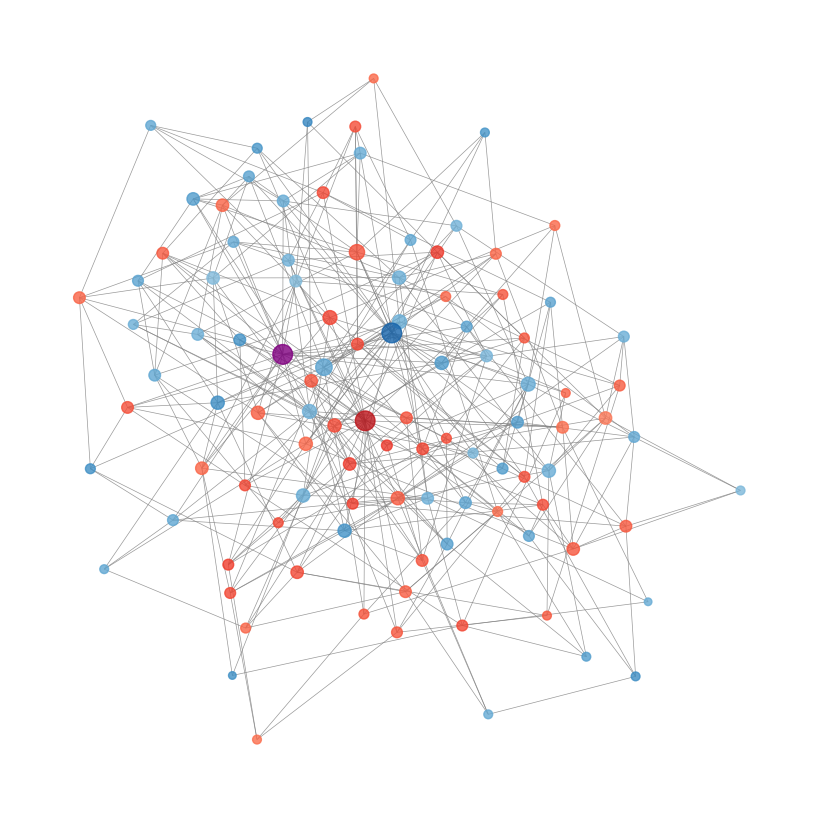

In [166]:
plot_graph(G, initial_df)

In [185]:
j = 3
# k = 6
final_G = None
with open(f'results/SE_results_new/graph_{k}{j}.pkl', 'rb') as f:
    final_G = pickle.load(f)
final_df = pd.read_csv(f'results/SE_results_new/final_data_{k}{j}.csv')

In [186]:
final_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'privacy', 'activity', 'satisfaction',
       'lat_acc', 'lat_rej', 'id', 'pol_inclination'],
      dtype='object')

103


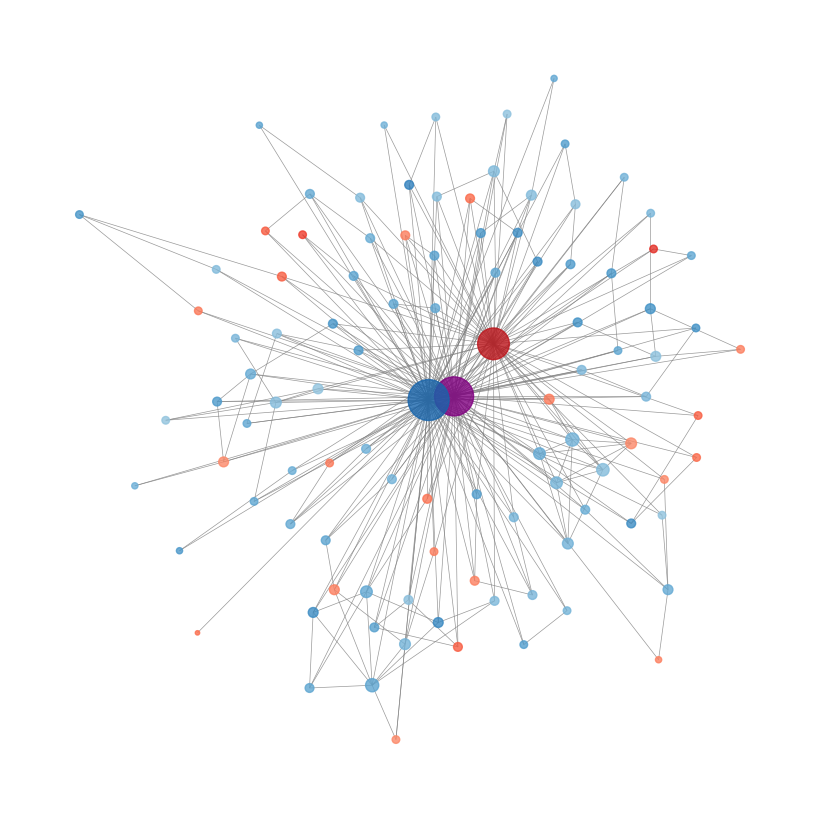

In [187]:
plot_graph(final_G, final_df)

In [188]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity
import numpy as np

def bin_stance(val):
    if val < -0.33:
        return -1
    elif val > 0.33:
        return 1
    else:
        return 0

def structural_polarization_metrics(G):
    results = {}

    # 1. Discretize stance
    for n, d in G.nodes(data=True):
        d['stance_bin'] = bin_stance(d['pol_inclination'])

    # 2. Categorical assortativity (homophily on discrete stance)
    results['categorical_homophily'] = nx.attribute_assortativity_coefficient(G, 'stance_bin')

    # 3. Community detection and modularity
    communities = list(greedy_modularity_communities(G))
    results['modularity'] = modularity(G, communities)

    # 4. Intra-community stance variance
    variances = []
    for community in communities:
        stances = [G.nodes[n]['pol_inclination'] for n in community]
        if len(stances) > 1:
            variances.append(np.var(stances))
    results['avg_intra_comm_variance'] = np.mean(variances)

    # 5. Boundary edge ratio (opposing stances)
    boundary_edges = [(u, v) for u, v in G.edges if G.nodes[u]['stance_bin'] * G.nodes[v]['stance_bin'] < 0]
    results['boundary_edge_ratio'] = len(boundary_edges) / G.number_of_edges()

    return results

In [189]:
# G is your graph with 'pol_inclination' ∈ [-1, 1] as a node attribute
results = structural_polarization_metrics(G)
for e, v in results.items():
    print(f"{e}: {v:.4f}")

categorical_homophily: 0.0762
modularity: 0.3206
avg_intra_comm_variance: 0.1498
boundary_edge_ratio: 0.1861


In [190]:
# G is your graph with 'pol_inclination' ∈ [-1, 1] as a node attribute
results = structural_polarization_metrics(final_G)
for e, v in results.items():
    print(f"{e}: {v:.4f}")

categorical_homophily: -0.0344
modularity: 0.2953
avg_intra_comm_variance: 0.0768
boundary_edge_ratio: 0.0680


In [191]:
import networkx as nx
import numpy as np
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities

def bin_stance(val):
    if val < -0.33:
        return -1
    elif val > 0.33:
        return 1
    else:
        return 0

def attribute_aware_metrics(G):
    results = {}

    # Binning stance for categorical metrics
    for n, d in G.nodes(data=True):
        d['stance_bin'] = bin_stance(d['pol_inclination'])

    # 1. Attribute-aware homophily (manual avg stance similarity over edges)
    edge_similarities = [
        1 - abs(G.nodes[u]['pol_inclination'] - G.nodes[v]['pol_inclination'])
        for u, v in G.edges()
    ]
    results['stance_similarity_avg'] = np.mean(edge_similarities)

    # 2. Attribute-aware modularity (manual: avg intra-community stance similarity)
    communities = list(greedy_modularity_communities(G))
    intra_sims = []
    for comm in communities:
        node_list = list(comm)
        if len(node_list) < 2:
            continue
        sims = [1 - abs(G.nodes[u]['pol_inclination'] - G.nodes[v]['pol_inclination'])
                for u, v in combinations(node_list, 2)]
        intra_sims.append(np.mean(sims))
    results['attribute_modularity'] = np.mean(intra_sims)

    # 3. Intra-community stance variance
    variances = []
    for comm in communities:
        stances = [G.nodes[n]['pol_inclination'] for n in comm]
        if len(stances) > 1:
            variances.append(np.var(stances))
    results['avg_intra_comm_variance'] = np.mean(variances)

    # 4. Boundary edge ratio (cross-bin edges)
    boundary_edges = [
        (u, v) for u, v in G.edges()
        if G.nodes[u]['stance_bin'] * G.nodes[v]['stance_bin'] < 0
    ]
    results['boundary_edge_ratio'] = len(boundary_edges) / G.number_of_edges()

    return results

In [192]:
# G is your graph with 'pol_inclination' ∈ [-1, 1] as a node attribute
results = attribute_aware_metrics(G)
for e, v in results.items():
    print(f"{e}: {v:.4f}")

stance_similarity_avg: 0.5076
attribute_modularity: 0.5474
avg_intra_comm_variance: 0.1498
boundary_edge_ratio: 0.1861


In [193]:
# G is your graph with 'pol_inclination' ∈ [-1, 1] as a node attribute
results = attribute_aware_metrics(final_G)
for e, v in results.items():
    print(f"{e}: {v:.4f}")0

stance_similarity_avg: 0.4103
attribute_modularity: 0.6709
avg_intra_comm_variance: 0.0768
boundary_edge_ratio: 0.0680


In [184]:
# G is your graph with 'pol_inclination' ∈ [-1, 1] as a node attribute
results = attribute_aware_metrics(final_G)
for e, v in results.items():
    print(f"{e}: {v:.4f}")

stance_similarity_avg: 0.3205
attribute_modularity: 0.6319
avg_intra_comm_variance: 0.0729
boundary_edge_ratio: 0.0658
